<center>
# OPTIMIZACIÓN DE LA POLÍTICA DE PRECIOS
<center>

## Introducción

La optimización de la política de precios sin lugar a dudas es uno de los elementos principales en la gestión de una cartera de produtos. Las alternativas abarcan tanto técnicas cualitativas como cuantitativas. Los ejemplos más característicos son el juicio experto, benchmarking con productos de la competencia, realizar de pequeños experimentos basados en encuestas, análisis de la elasticidad del precio, etc. En esta ocasión se va a ensayar un enfoque puramente cuantitativo basado en la predicción de la cantidad vendida y se aprovechará para mostrar el funcionamiento del algoritmo fundamental en Machine Learning (ML), el Descenso por Gradiente (o Gradient Descent).

En primer lugar, se lleva a cabo un **análisis descriptivo** que permita abordar la siguiente etapa de **modelado predictivo**. de la cantidad vendida en función del precio de venta. Este modelo proporciona una relación entre las variables mencionadas, y a partir del mismo se obtienen los ingresos en función del precio de venta. En la última fase, gracias al **análisis prescriptivo** de la función de ingresos, se determina la política de precios mediante el algoritmo de optimización.

El dataset contiene la serie temporal del precio minorista y el consumo de carne de ternera, que en adelante serán el precio de venta (p) y la cantidad vendida (q). Se estructura cuatrimestralmente y abarca 1997Q1 hasta 1999Q3. Los datos se toman del ejemplo de SAS ETS: Calculating Price Elasticity of Demand

FUENTE: https://support.sas.com/rnd/app/ets/examples/simpelast/sas.htm

SOFTWARE: Jupyter Notebook de SAS University Edition. Versión SAS 9.4. SAS IML (Interactive Matrix Language).

In [1]:
libname lab ".";/*Ruta relativa, el notebook y el dataset deben estar en la misma carpeta*/
data inputData;
    set lab.inputData;
    r=p*q;
RUN;

title "Metadatos";
PROC CONTENTS DATA=inputData OUT=metadata NOPRINT;RUN;
PROC PRINT DATA =metadata; 
	var name type length format;
RUN;
title "Primeras 10 observaciones";
PROC PRINT DATA =inputData (OBS=10); RUN;
title "Resumen estadísticas descriptivas";
PROC MEANS DATA=inputData N NMISS MAX MIN MEAN MEDIAN STD; 
    var yr q p r;
RUN;



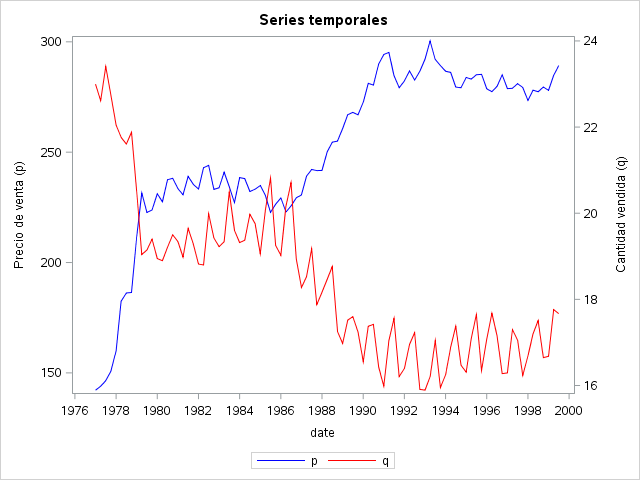
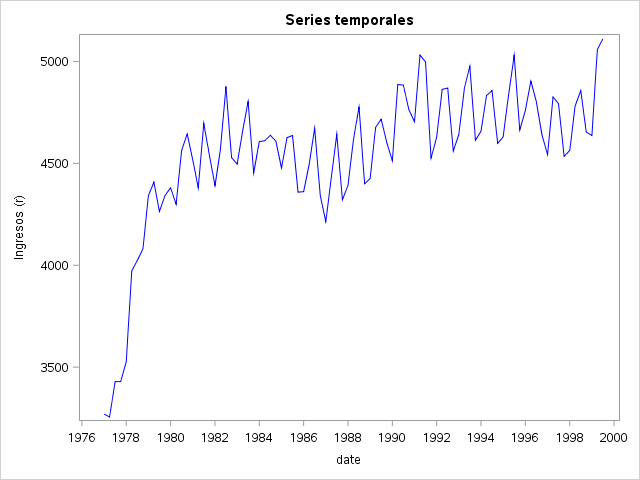

In [23]:
ODS graphics / imagemap=ON;/*Situando el cursor sobre un punto del grafico, aparecen los valores del dataset en esa observacion*/

title "Series temporales";
PROC SGPLOT DATA=inputData;
	series x=date y=p / lineattrs=(color=blue) tip=(p q r date);
	series x=date y=q / lineattrs=(color=red) y2axis tip=(p q r date);
	y2axis label="Cantidad vendida (q)";
    yaxis label="Precio de venta (p)";
RUN;
PROC SGPLOT DATA=inputData;
    series x=date y=R / lineattrs=(color=blue) tip=(p q r date);
    yaxis label="Ingresos (r)";
RUN;
title;


En esta visualización inicial de las series temporales, se observa una primera etapa con un fuerte incremento del precio de venta (p) y los ingresos (r) debido a que la cantidad vendida (q), aunque va decreciendo, se mantiene elevada hasta 1979.

Posteriormente, los ingresos (r) se mantienen hasta aproximadamente el final de la década de los 80, para sufrir un ligero incremento en la parte final. En el segundo periodo, el precio de venta (p) y la cantidad vendida (q) se mantienen estables, momento en el cual sufren una variación para volverse a estabilizar nuevamente en el intervalo final.

Objetivo: Dado un dataset en el que aparecen como variables la cantidad vendida (q) y el precio de venta (p) la meta es determinar el precio óptimo de venta (p=P) para maximizar los ingresos (r=R) en el siguiente periodo t+1.

Con esta fininalidad, se apoya el análisis en una expresión de la cantidad vendida (q) como la que sigue:

$$ \text{modelo lineal: } q_{t+1}=f(q_{t-\tau},p)= \beta_{0}+ \beta_{1}q_{t-1}+...+\beta_{\tau}q_{t-\tau}+\beta p_{t+1}$$

Es decir, en esta etapa predictiva, se modela la cantidad vendida (q) como una función de la misma variable en periodos anteriores y del precio de venta (p). A partir de la misma, se pueden obtener los ingresos (r) como función del precio de venta (p):

$$ r_{t+1}= q_{t+1} p_{t+1} $$

Se trata de encontar el máximo de la curva los ingresos (r), esto es, el punto (P, R). Para ello, se emplea un algoritmo de optimización (Gradient Descent), esta parte constituye la fase prescriptiva del ejercicio.

Este objetivo analítico se emplea como justificación para explorar y ensayar esta metodología así como para ilustrar el funcionamiento del algoritmo de Gradient Descent, por lo que se mantendrá  la parte de modelado predictivo lo más sencilla posible.

El desarrollo que sigue abarca las siguientes etapas:
1. Análisis exploratorio de los datos (EDA por sus siglas en inglés)
2. Construción del modelo lineal y determinación del precio de venta óptimo P mediante Gradient Descent
3. Análisis de los resultados
4. Comentarios finales

Addendum: Selección de parámetros del algoritmo Gradient Descent y análisis de convergencia

## 1. Análisis exploratorio de datos


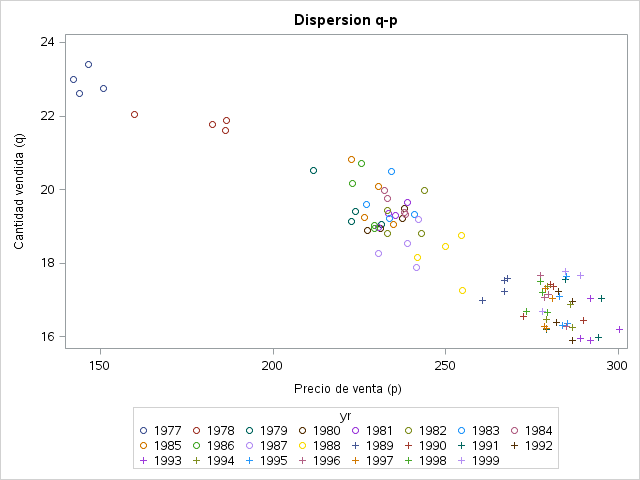

In [24]:
title "Dispersion q-p";
PROC SGPLOT DATA=inputData;
	scatter x=p y=q / group=yr tip=(yr qtr p q);
    yaxis label="Cantidad vendida (q)";
    xaxis label="Precio de venta (p)";
RUN;
title;
title "Matriz de correlacion";
PROC CORR DATA=inputData NOSIMPLE; 
	var q p;
RUN;
title;

En el gráfico de dispersión p-q se observa que existe una fuerte relación lineal con pendiente negativa entre la cantidad vendida (q) y el precio de venta (p). En la matriz de correlación, se aprecia que el valor de la misma es muy próximo a -1 y estadísticamente significativo.


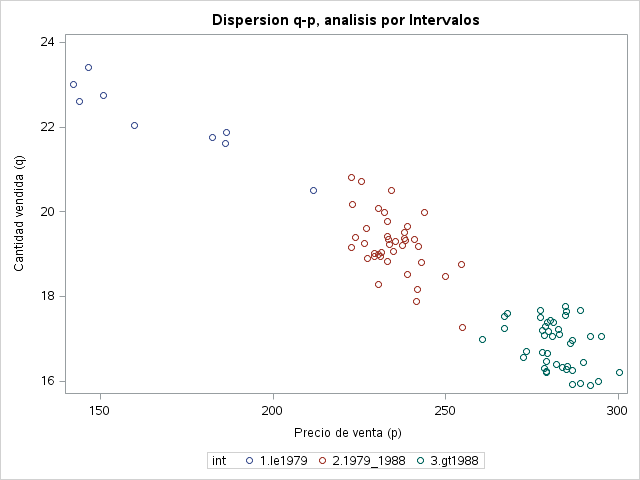
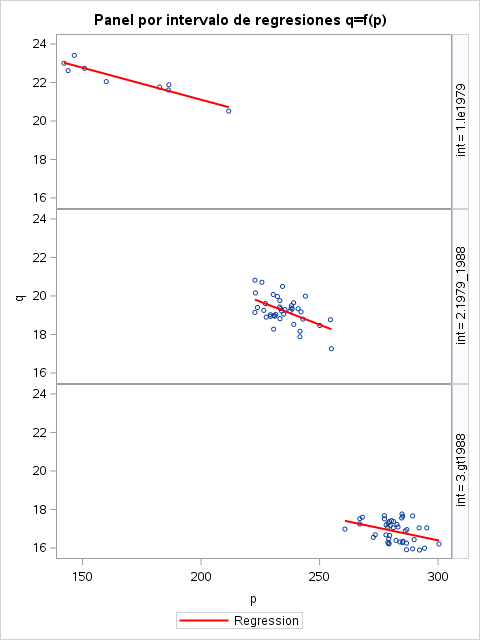
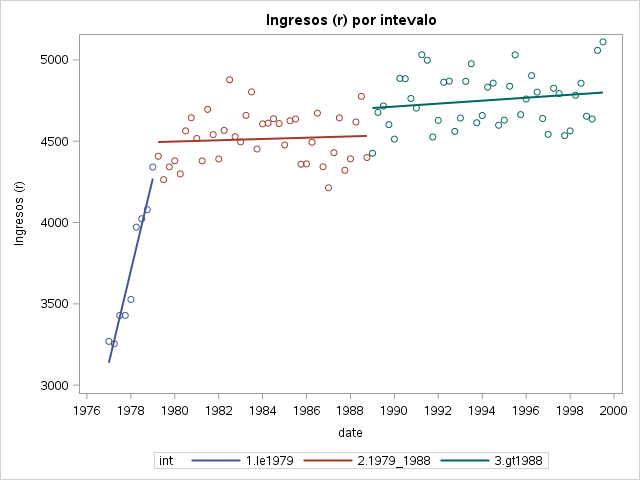

In [20]:
/*
 * Se crean tres intervalos de analisis, divididos por las fechas: 1979Q1, 1985Q4
*/
DATA EDA1;
	set inputData;
	format int $15.;
	if date <= '01JAN1979'd then int="1.le1979"; 
	else if date <= '31DEC1988'd then int="2.1979_1988"; 
	else int="3.gt1988";
RUN;
title "Dispersion q-p, analisis por Intervalos";
PROC SGPLOT DATA=eda1;
	scatter x=p y=q / group=INT tip=(yr qtr p q);
    yaxis label="Cantidad vendida (q)";
    xaxis label="Precio de venta (p)";
RUN;
title;

title "Panel por intervalo de regresiones q=f(p)";
PROC SGPANEL DATA=eda1;
	panelby int / LAYOUT=rowlattice;
	reg x=p y=q / lineattrs=(color=red) tip=(qtr p q);
RUN;
title;
title "Ingresos (r) por intevalo";
PROC SGPLOT DATA=EDA1;
    reg x=date y=R / group=int /*lineattrs=(color=red)*/;
    yaxis label="Ingresos (r)";
RUN;
title;

Tal y como se puntualizó en la visualización de las series temporales, es interesante realizar un análisis por intervalos. A partir del mismo, se determina que hasta 1979 se da una etapa de grandes cantidades vendidas y precios de venta bajos, hasta 1988 una etapa intermedia, siendo el último periodo de precios mayores y menor cantidad vendida. 

En el panel de regresiones, los tres intervalos muestran una pendiente casi constante. Esta pendiente se conoce como elasticidad de la demanda y representa la sensibilidad (variación) de la misma al variar el precio. Un valor pequeño (pendiente casi horizontal) significa que la demanda puede sufrir grandes cambios al variar ligeramente el precio. Esta situación se denomina demanda elástica, y es el comportamiento típico cuando el producto no es esencial o existen productos sustitutivos, tal y como ocurre en este ejemplo (carne de ternera).  

Sin embargo, en el apartado de los ingresos, en el primer periodo se produce un fuerte aumento, estabilizándose la tasa de incremento de los mismos en los periodos siguientes (pendientes casi paralelas). Debido a esta pequeña pendiente, el nivel de ingresos es ligeramente mayor en el último periodo.


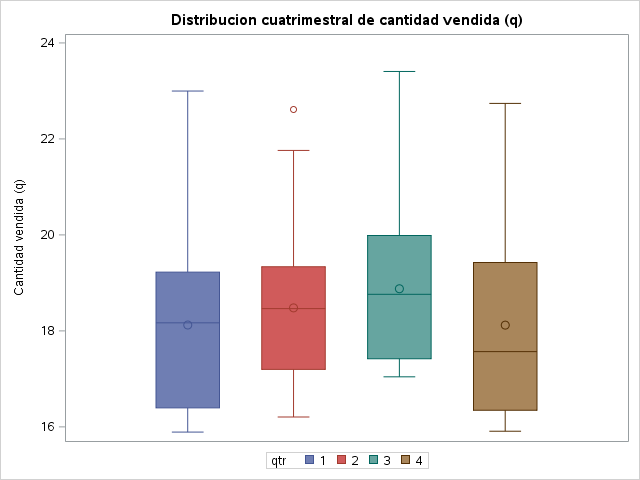
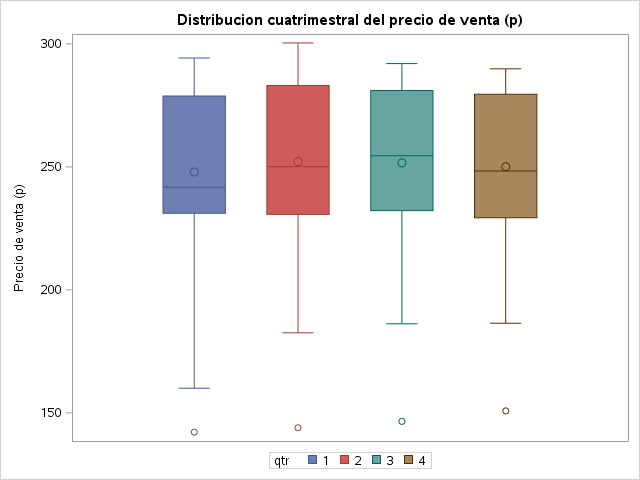

In [7]:
title "Distribucion cuatrimestral de cantidad vendida (q)";
PROC SGPLOT DATA= inputData;
	Vbox q / group=qtr;
    yaxis label="Cantidad vendida (q)";
RUN;
title;
title "Distribucion cuatrimestral del precio de venta (p)";
PROC SGPLOT DATA= inputData;
	Vbox p / group=qtr;
    yaxis label="Precio de venta (p)";
RUN;
title;

Los diagramas boxplot (caja y bigotes) por cuatrimestre señalan que las medias de la cantidad vendida (q) y del precio de venta (p) varían cuatrimestralmente, por lo que se evidencia la presencia de una componente estacional. Adicionalmente, se puede comprobar que la variabilidad en cada cuatrimestre tanto de la cantidad vendida (q) como del precio de venta (p) es bastante similar, con excepción del primer cuatrimestre para el precio de venta (p)


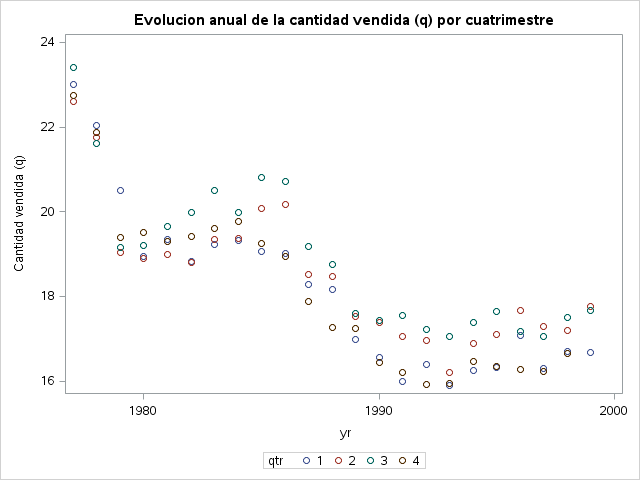
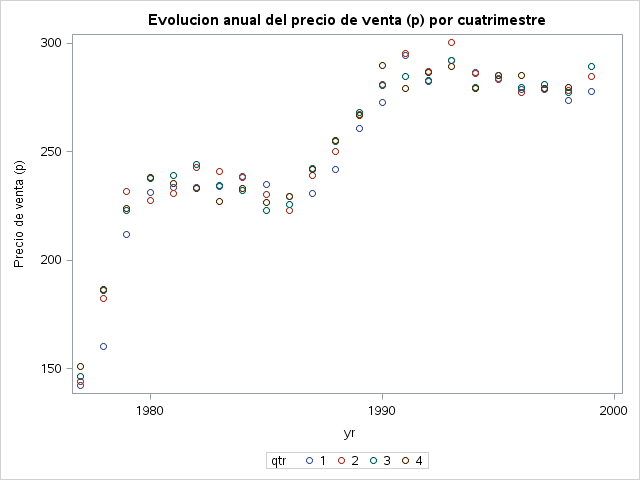

In [22]:
PROC SGPLOT DATA=inputData;
	title "Evolucion anual de la cantidad vendida (q) por cuatrimestre";
	scatter x=yr y=q / group=qtr tip=(yr qtr p q);
    yaxis label="Cantidad vendida (q)";
RUN;
title;
PROC SGPLOT DATA=inputData;
	title "Evolucion anual del precio de venta (p) por cuatrimestre";
	scatter x=yr y=p / group=qtr tip=(yr qtr p q);   
   yaxis label="Precio de venta (p)";
RUN;
title;

Así mismo, si se observa la distribución anual de la cantidad vendida (q) o del precio de venta (p) por cuatrimestre se detecta una compontente de tendencia, de tal forma que la cantidad vendida (q) disminuye año a año y el precio de venta (p) sufre el comportamiento contrario.

### Conclusiones extraídas del análisis exploratorio de datos:

1. Existe una fuerte correlación negativa entre la cantidad vendida (q) y el precio de venta (p). Además la pendiente de la línea de ajuste (modelo de elasticidad) es negativa.

2. Esta pendiente es aproximadamente constante en los tres invervalos.

3. Existe una componente estacional con periodo anual tanto en la cantidad vendida (q) como en el precio de venta (p)

4. Del mismo modo, se ha detectado una componente de tendencia en ambas variables, negativa en el primer caso y positiva en el segundo.

Cabe destacar la importancia de esta fase de exploración previa, que permite dar forma al modelo lineal que se pretende construir

## 2. Construción del modelo lineal y determinación del precio P mediante Gradient Descent

Como punto de partida, se propone el siguiente modelo:

$$ \text{modelo lineal: } q_{t+1}=\beta_{0} + \beta_{1} q_{t-1} + \beta_{2} q_{t-4} + \beta_{3} p_{t+1}$$

Se emplea una estrategia de selección de modelo sencilla, basada en el familiar coeficiente R2 ajustado. El mismo expresa la cantidad de variabilidad que es capaz de explicar el modelo frente a la variabilidad existente en el dataset, ajustado por el número de variables independientes que intervengan. Queda fuera del alcance de este ejercicio desarrollar la estrategia de selección y evaluación de modelos. 

El proceso consiste en entrenar el modelo en un subconjunto de datos que abarca hasta el periodo t, que constituye la relación entre la cantidad vendida (q) y el precio de venta (p) en el periodo t+1. Esta relación se emplea para hallar los ingresos en el periodo t+1 y determinar el punto (P, R). Por lo tanto, se deja la última observación (periodo t+1) para analizar la parte de optimización.



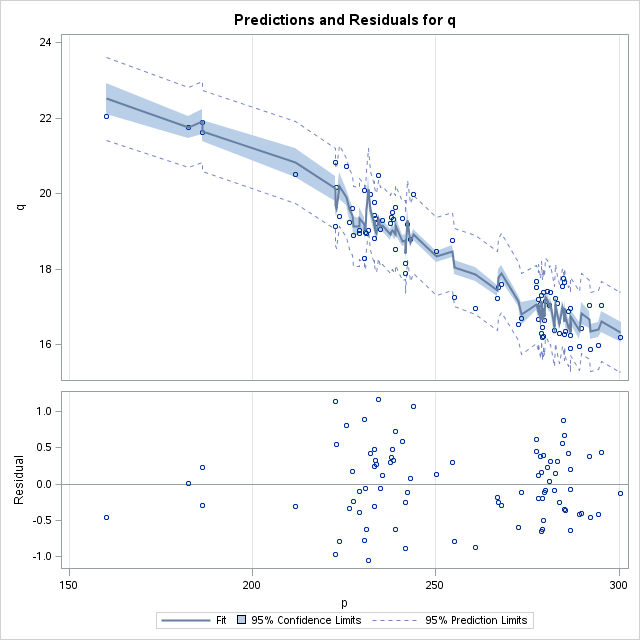
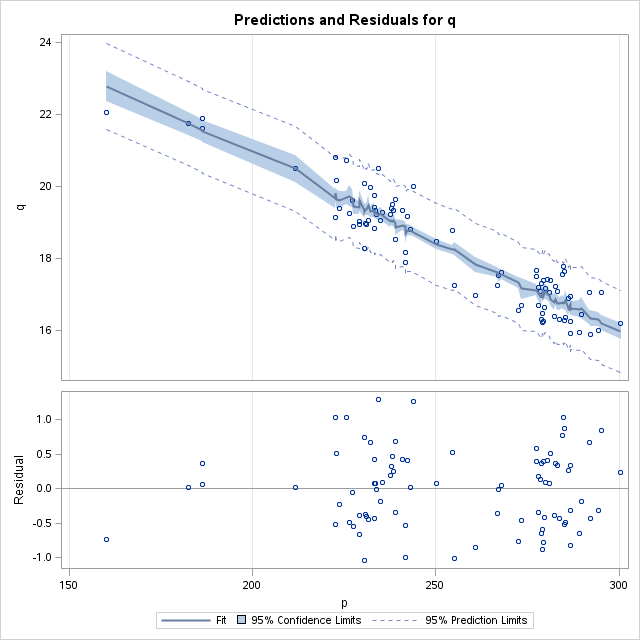
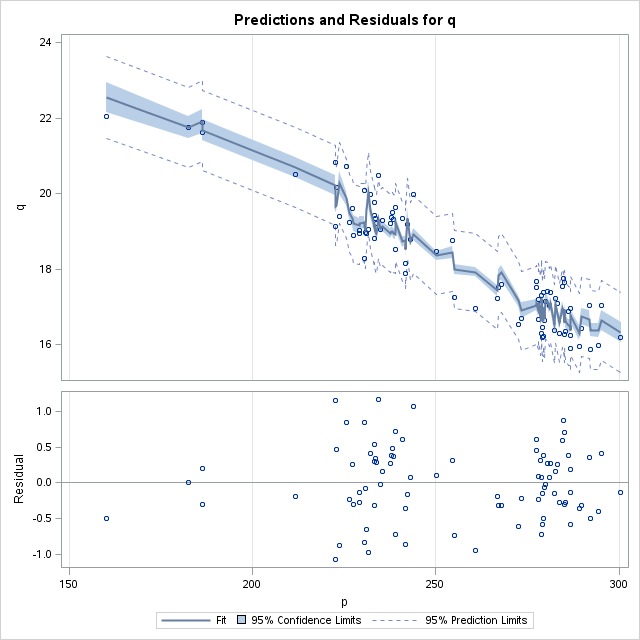

In [3]:
/*Separacion de la ultima observacion seleccion del precio real en el periodo t+1 para constrastar resultados*/
DATA train test;
    set inputData END=eof;
    qlag1=lag(q);
	qlag4=lag4(q);
    if  eof then do;
    	output test;
    	call SYMPUTX('testPrice',p);
    end;
    else output train;
RUN;
/*
* Ensayo y seleccion de modelos
*/
PROC REG DATA=train OUTEST=CoefReg PLOTS(ONLY)= (PREDICTIONS(X= p) );
	model1 : model q=qlag1 qlag4 p / ADJRSQ; 
	model2 : model q=qlag1 p / ADJRSQ;
	model3 : model q= qlag4 p / ADJRSQ;
RUN;

El modelo elegido es el etiquetado como model3, que solo depende de qlag4. La razón es que presenta el mayor valor de R2 ajustado, menor número de coeficientes y estos son significativos. Nótese que no se usan todas las observaciones ya que existen valores nulos (missing) debido al cálculo de las variables lag.

In [12]:
PROC PRINT DATA=coefreg;
	ID _MODEL_;
	VAR _ADJRSQ_;
RUN;

_MODEL_,_ADJRSQ_
model1,0.89246
model2,0.87077
model3,0.89267


In [4]:
/*
* Se acondiciona el dataset de coeficientes de la regresion para separar lo que dependa del precio (variable beta)
* de lo constante (variables beta0 y beta1)
*/

/*Seleccion del model3 y renombrado de las variables que contienen los coeficientes del modelo*/
DATA CoefReg;
    set CoefReg (where=(_MODEL_="model3"));
    RENAME intercept=beta0 p=beta  qlag4=qlag4_coef;
    KEEP intercept p qlag4;
RUN;

/*Se junta el dataset test con el de coeficientes, para obtener la expresion final*/
DATA Betas (KEEP=beta:) report_Reg (KEEP=date q p);
	merge CoefReg test;
	beta1=qlag4*qlag4_coef;
RUN;

/*
* beta0: Intercept de la regresion lineal
* beta1: Resultado de multiplicar el valor de qlag4 en la observacion a estimar (t+1) por el coeficiente correspondiente de la regresion
* beta: Coeficiente de la regresion lineal relativo a p
*/

PROC PRINT DATA=Betas NOOBS; RUN;

beta0,beta,beta1
19.4229,-0.029526,5.97468


Tomando el modelo construido anteriormente, se obtiene la expresión de los ingresos (r):

$$ r_{t+1} = q_{t+1}p_{t+1} =\beta_{0} p_{t+1} + \beta_{1} q_{t-4} p_{t+1} + \beta p_{t+1}^2$$

Como puede obsevarse, los ingresos del siguiente periodo son función únicamente del precio de venta en dicho periodo (dado que los lags de q son constantes para un periodo dado). Por lo tanto es una expresión sencilla en función de p[t+1] , ideal para explicar el proceso de optimización que obtendrá el punto (P,R), se simplificará la notación:

$$ p_{t+1}=p $$ 
$$ q_{t+1}=q $$
$$ r_{t+1}=r $$

El algoritmo de Gradient Descent trata de encontrar un extremo local (máximo/mínimo) de una función objetivo, que  en este caso son los ingresos (r). Esta función tiene una serie de argumentos, para este ejemplo, solo depende de del precio de venta (p). Por lo tanto, la función objetivo tiene la forma r=f(p). 

Se comienza con un valor inicial del argumento y se evalúa la función objetivo en dicho valor. Posteriormente, se incrementa el argumento en un valor (paso) que depende de un parámetro (alpha) y del gradiente (pendiente) de la función objetivo (de ahí el nombre). A continuación, se  reevalúa la función objetivo en este nuevo punto y se obtiene la diferencia antes y después de dar el paso. Se repite el proceso de actualización del argumento y obtención de diferencias hasta que estas son suficientemente pequeñas.
https://en.wikipedia.org/wiki/Gradient_descent

Si y es la función objetivo y esta tiene un conjunto de argumentos x[1], x[2], ..., x[p] que se agrupan en un vector llamado x, en la iteración t, el algoritmo se expresa como sigue:

1.Actualizar valor de los argumentos:
$$ \vec{x}_{t+1} = \vec{x}_{t} \pm \alpha \nabla y(\vec{x}=\vec{x}_{t}) $$


2.Evaluar el valor de la función objetivo en el nuevo punto:
$$   y_{t+1} =  f( \vec{x}_{t+1}) $$


3.Calcular la diferencia de la función objetivo entre la iteración actual y la anterior:
$$  \Delta_{t} =  y_{t} -  y_{t+1} $$


Simplificando para un solo argumento llamado x:

1.Actualizar valor del argumento:
$$ x_{t+1} = x_{t} \pm \alpha \frac{dy(x)}{dx}(x=x_{t}) $$


2.Evaluar el valor de la función objetivo en el nuevo punto:
$$   y_{t+1} =  f(x_{t+1}) $$


3.Calcular la diferencia de la función objetivo entre la iteración actual y la anterior:
$$  \Delta_{t} =  y_{t} -  y_{t+1} $$

Gráficamente, lo que se hace es recorrer la función de objetivo, dando pequeños pasos en los valores de los argumentos. El sentido de estos pasos viene determinado por la regla de actualización que depende de la pendiente de la curva, de tal forma que se dirige en el sentido en el que se incrementa la función objetivo hasta llegar al máximo local.

Se ha desarrollado el algoritmo utilizando el lenguaje IML de SAS, el mismo tiene cuatro parámetros:

+ alpha: También conocido como ratio de aprendizaje, controla la magnitud del paso y determina la velocidad y capacidad de converger a una solución del algoritmo.
Un valor demasiado bajo asegura la convergencia pero ralentiza el proceso, ocasionando lo opuesto la situación contraria. 

+ epsilon: Umbral que detiene el algoritmo si las diferencias el valor de la función objetivo de dos iteraciones sucesivas son inferiores al mismo. En tal caso el algoritmo habrá convergido a una solución

+ maxIter: Número máximo de iteraciones
+ intialPrice: Estimación inicial del argumento.

El algoritmo asegura la convergencia hacia un extremo **local** (bajo unas condiciones determinadas), sin embargo, se puede aplicar al caso contemplado con seguridad, dado que la curva tiene forma parabólica y su máximo local es también global.

Se dice que es el algoritmo fundamental en ML, porque se emplea en la determinación de los coeficientes del modelo predictivo. En este caso, la función objetivo es una función de coste (una métrica del error de predicción), los argumentos son estos coeficientes y se desarrolla contra el gradiente para encontrar el mínimo, es decir, el conjunto de coeficientes que minimiza el error de predicción. Obviamente, existen versiones más avanzadas y otros algoritmos más eficientes que se usan en las implementaciones de los modelos de las librerías de ML más conocidas.

A continuación, se seguirá la siguiente nomenclatura de las variables:

+ p_hist, q_hist: Valores del argumento (precio de venta) y de la cantidad vendida (q) en cada iteración del algoritmo
+ r_hist: Valores de la funcion objetivo en cada iteración
+ delta_hist: Diferencia entre los valores de la función objetivo en la iteración actual y la anterio para cada paso del algoritmo.
+ it: Número de la iteración


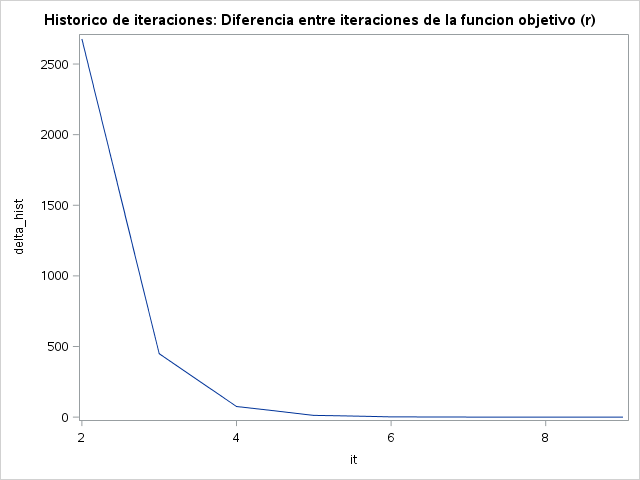
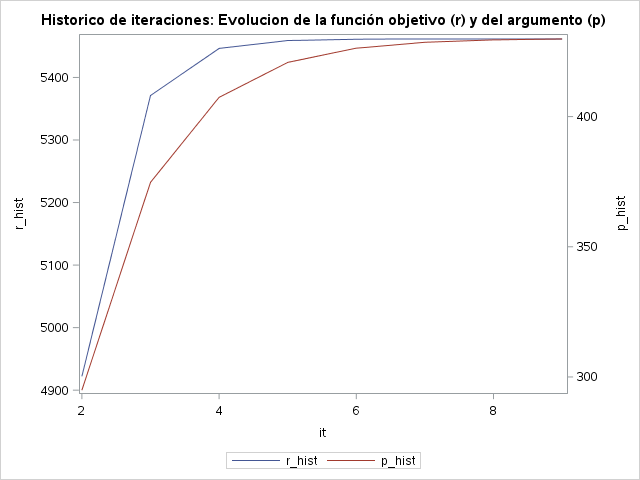

In [19]:
/*
* Gradient Descent
*/

/*Parametros del algoritmo*/
%LET alpha=10;
%LET maxIter=15;
%LET epsilon=0.01;
%LET intialPrice=100;

PROC IML;
    /*Se convierte el dataset en un vector columna*/
	use Betas;
    read all var {beta0 beta1 beta} ;
    close Betas;
    
    print beta0 beta1 beta;
    
    /*Inicialización de vectores para almancenar los resultados de cada iteracion*/
    p_hist={.};
    q_hist={.};
    r_hist={.};
    delta_hist={.};
    it={.};
 
    p_hist[1]=&intialPrice;
    q_hist[1]=beta0 + beta1 + beta*p_hist[1];
    r_hist[1]=q_hist[1]*p_hist[1];
    
    delta=1+&epsilon;
    delta_hist[1]=.;
    
    i=1;	it[1]=i;
    
   do while (i<&maxIter & delta>=&epsilon);
   /*En cada iteracion se calculan los valores actuales como escalares y se apendizan a los vectores (columna) correspondientes*/
    	i=i+1;	it= it // i;
        /*1. Actualizar argumento p con la regla del gradiente*/
    	pact = p_hist[i-1]+&alpha*( beta0 + beta1 + 2*beta*p_hist[i-1] );
    	p_hist = p_hist // pact;
    	
        /*2. Evaluar funcion objetivo con el argumento actualizado, primero se calcula q y posteriormente r*/
    	qact= beta0 + beta1 + beta*p_hist[i];
    	q_hist = q_hist // qact;
    	
    	ract= p_hist[i]*q_hist[i];
    	r_hist = r_hist // ract;
    	
        /*3. Calcular la diferencia entre el valor de la funcion objetivo de la iteracion actual y la anterior*/
    	delta=abs(r_hist[i]-r_hist[i-1]);
    	delta_hist = delta_hist // delta;
    end;
   
   /*Se entrega como output el dataset con los resultados de cada iteracion para su posterior analisis*/

    create hist_conv var {"it" "p_hist" "q_hist" "r_hist" "delta_hist"} ;
    append ;
    close hist_conv;
QUIT;

title "Historico de iteraciones: Diferencia entre iteraciones de la funcion objetivo (r)";
PROC PRINT DATA=hist_conv NOOBS;
RUN;

PROC SGPLOT DATA=hist_conv (FIRSTOBS=2);
	series x=it y=delta_hist /tip=(it);
RUN;
title;
title "Historico de iteraciones: Evolucion de la función objetivo (r) y del argumento (p)";
PROC SGPLOT DATA=hist_conv (FIRSTOBS=2);
	series x=it y=r_hist /tip=(it);
    series x=it y=p_hist / y2axis tip=(it);
RUN;


En este punto, hay que destacar **la importancia de analizar el desarrollo del algoritmo**, los puntos clave son:

1. Determinar por qué razón finaliza el algoritmo. En este caso se observa en la tabla del histórico de iteraciones que acaba en iteración 9 debido a que las diferencias de la función objetivo entre iteraciones están por debajo del umbral epsilon.

2. En el gráfico de Evolución de las diferencias (delta_hist) se puede verificar que decrecen monotonamente. En caso contrario habría que probar con un valor del ratio de aprendizaje inferior. Además, son muy pequeñas al finalizar el algoritmo, es decir, tienden a cero. Si esto no fuera así, sería necesario aumentar el número de iteraciones máximas o aumentar el ratio de aprendizaje.

3. Por último, se comprueba la estabilidad de la solucion analizando el gráfico de Evolución de los argumentos (en este caso p) y la función objetivo (r), que claramente convergen a los valores P y R, respectivamente. Si tuvieran otro comportamiento (oscilatorio) es síntoma de que hay que reducir el ratio de aprendizaje.

Tras este análisis se está en condiciones de afirmar que la solución alcanzada es satisfactoria. Es un ejercicio muy interesante modificar los parámetros del algoritmo y analizar el resultado de la convergencia, razón por la cual se llevará a cabo al finalizar el análisis actual como un breve addendum.

## 3. Análisis de los resultados

date,q,p,r,q[t+1],P,R
1999Q3,17.6689,289.2333,5110.434,12.7065,429.825,5461.57

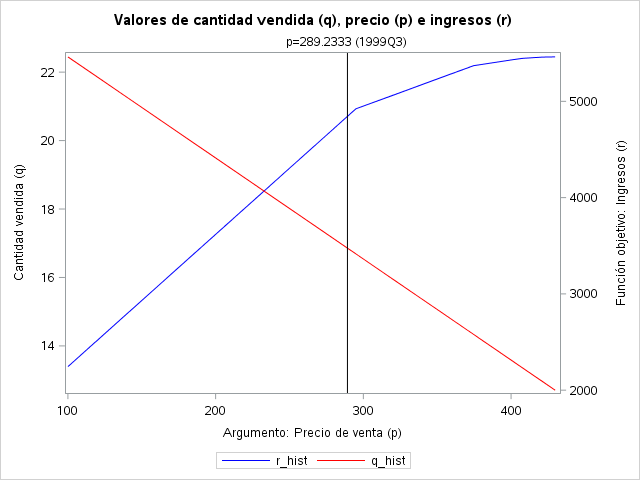

In [7]:
title "Valores de cantidad vendida (q), precio (p) e ingresos (r)";
PROC SGPLOT DATA=hist_conv;
	series x=p_hist y=r_hist / y2axis lineattrs=(color=blue) tip=(it p_hist r_hist);
	series x=p_hist y=q_hist /lineattrs=(color=red)  tip=(it p_hist q_hist);
	refline &testPrice / axis=x label="p=&testPrice (1999Q3)" lineattrs=(color=black);
    yaxis label="Cantidad vendida (q)";
    y2axis label="Función objetivo: Ingresos (r)";
    xaxis label="Argumento: Precio de venta (p)";
RUN;
title;
DATA hist_conv_last;
    set hist_conv END=eof;
    if eof;
RUN;

DATA report_reg;
    format date yyq6. p q r 8.4;
    merge report_Reg hist_conv_LAST;
    label p_hist="P" q_hist="q[t+1]" r_hist="R";    
    r=p*q;
    DROP it delta_hist;
RUN;
PROC PRINT DATA= report_reg noobs labels; 
    id date;
    var q p r q_hist p_hist r_hist;
RUN;
title;

En este gráfico se observa en rojo (eje izquierdo) la cantidad venida (q) y en azul (eje derecho) los ingresos (r) en cada iteración. Se aprecia que la forma de la curva de ingresos es una parábola. Este es el resultado esperado, ya que proviene de una expresión lineal en el precio de venta (p), y que efectivamente alcanza un máximo. Como es una parábola, el máximo local es también global.

Para 1999Q3 se llega a un resultado con unos ingresos óptimos (R) superiores a los que se produjeron realmente (r), debido principalmente a un agresivo aumento del precio de venta (P) que compensa el descenso de la cantidad vendida (q[t+1])

Por último, si se toma el valor real del precio de venta (p=289.23, línea vertical negra) y se introduce en el modelo, se estarían infraestimando los ingresos (r) pero la meta del ejercicio no es estimar los mismos sino buscar el punto en el que se sospecha que pueden ser máximos. Analizando el entorno del punto (P,R) de la curva de ingresos, se puede disminuir significativamente el precio de venta (p) con respecto a P sin alejarse significativamente del punto óptimo. Esta parte del análisis es vital, ya que el valor del mismo radica principalmente en la dirección de la política de precio más que en proporcionar una cifra concreta. Posteriormente, quedaría a criterio del analista el dar un valor concreto, en función del análisis cuantitativo que se ha llevado a cabo.

## 4. Comentarios finales

Se concluye el desarrollo del notebook con algunos comentarios finales:

+ Generalización: Para ilustrar la metodología, se han empleado un dataset y un modelo lineal sencillos, que generan una expresión de los ingresos (r) con forma parabólica. En general, se puede modelar como un polinomio de grado mayor y añadir más variables con el rol de argumentos.

$$  y = \sum_{j=1}^{p}  \sum_{i=0}^{d_{j}} \theta_{i}^{(i)}x_{j}^{i}$$

    En donde y es la función objetivo y las variables x[1], x[2],..., x[p] son los argumentos, que en general presentan términos polinómicos. En el siguiente ejemplo, se muestra una funcion objetivo de los ingresos que dependen del precio de venta de dos productos (1) y (2), cada producto se  modela con un polinomio de grado 2:

$$ y = \theta_{0} + \theta_{1}^{(1)}x_{1} + \theta_{2}^{(1)}x_{1}^{2} + \theta_{1}^{(2)}x_{2} + \theta_{2}^{(2)}x_{2}^{2} $$

    Este ejemplo representara un caso de dos productos sustitutivos o complementarios de la misma compañía en los que se quiere establecer el precio de venta de manera conjunta para maximizar los ingresos totales.

+ Inclusión de los costes: En aras de simplificar el proceso sin perder de vista que la meta es ensayar una metodología y presentar las herramientas utilizadas, se ha obviado la inclusión de los costes ya que no supone una pérdida de generalidad, por lo tanto la función objetivo son los ingresos en lugar de del beneficio (unitario bruto). En caso de que se desease expandir el análisis, bastaría con obtener esta función de beneficio (b) como la diferencia entre los ingresos (r) y un modelo de costes (c), por ejemplo de forma polinómica en función de la cantidad vendida (q):

$$ c_{t+1}(q_{t+1}) = \theta_{0}^{(c)} + \theta_{1}^{(c)}q_{t+1} + ... + \theta_{d}^{(c)}q_{t+1}^{d} $$

+ Construcción del modelo predictivo: Se ha optado por no profundizar en el paso de obtención del modelo y se ha presentado solo una breve introducción. En una aproximación más avanzada, se recomienda emplear mejores herramientas de construcción del modelo y estrategias selección del mismo mediante validación. Para construir apropiadamente el modelo, habría que tener en cuenta la autocorrelación entre las observaciones (al ser una serie temporal) y la correlación entre los argumentos, y finalmente realizar un diagnóstico de residuales para determinar en qué grado las condiciones estadísticas del tipo de modelo empleado se cumplen. Como estrategia de selección, sería conveniente complementar empleo del coeficiente R2 ajustado, con el cálculo de alguna métrica de predicción (como RMSE, Root Mean Square Error) en un dataset de validación, constituido por algunas observaciones del dataset de entrenamiento (por ejemplo el último año).


+ Forma del modelo de cantidad vendida (q): Es conveniente destacar en este punto, que este modelo debe generar una curva de ingresos (r) que tenga sentido de negocio. En general, debe cumplir la ley de rendimientos decrecientes, esto es, para valores bajos el precio de venta (p) deben aumentarse lo ingresos (r) al aumentar el primero, una zona en el que este comportamiento se satura y alcanza el máximo (óptimo de precio) y finalmente, si se sigue aumentado el precio de venta (p), solo se conseguiría disminuir los ingresos (r). Hay que tener en cuenta que si se emplea una regresión polinómica de grado d, los ingresos (r) tendrán grado d+1, por lo que este comportamiento **no está asegurado**. Hay que restringir análisis al dominio (rango de valores del precio de venta) en el que tenga sentido, y en general, limitarse a interpolar. Otra función intersante para esta relación q-p es la potencial (Ax^B) o utilizar GAMs (por sus siglas en inglés Generalized Additive Models, en los que se emplean como predictores funciones de las variables originales). En este caso, solo habría que modificar el cálculo del gradiente (derivida) en el algoritmo de optimización.

$$ \text{Ejemplo de GAM: } q_{t+1} = \beta_{0} + \beta_{1}q_{t-\tau} + \beta_{2}f(p_{t+1})$$

+ Construcción del dataset: Es necesario abarcar un periodo de tiempo suficientemente extenso como para poder construir los modelos, pero a la vez no tan grande como para observar cambios significativos en el funcionamiento del mercado. En este ejemplo, aunque la cantidad vendida (q) y el precio de venta (p) varíen, la relación entre los mismos (pendiente de la regresión q-p) es constante y los ingresos bastante estables (salvo el primer intervalo). En este punto, hay que tener en cuenta cambios tecnológicos o en la competencia, fases del ciclo de vida del producto, madurez del mercado, etc. También habría que estudiar la introducción de ajustes por la variación del valor del dinero en el tiempo y por el tipo de cambio si el producto se vende en varios mercados y se quieren modelar conjuntamente. Atención especial merecen también las promociones y/o rebajas que ayudarán a determinar la curva en la zona de precios de venta (p) bajos.


+ Robustez del análisis: Se recuerda que el objetivo es no es predictivo sino prescriptivo, a saber, no es obtener predicciones de la cantidad vendida (q) muy precisas, sino apoyar cuantitativamente la decisión de la política de precios indicando una dirección de actuación. Esto se consigue observando el entorno del punto (P, R) y en qué posición se está actualmente con respecto al mismo, más que el punto en sí. Por esta razón, debe priorizarse el análisis de sensibilidad y la contextualización del resultado sobre el desarrollo de un modelo predictivo de la cantidad vendida (q) muy complejo y preciso. En definitiva, la meta del modelo no es hacer predicciones muy precisas sino expresar una relación entre las variables suficientemente buena, pudiéndose dar el caso en el que un modelo con mayor poder predictivo (y a priori más costoso de desarrollar) apenas afecte al resultado del precio óptimo (aunque la estimación de cantidad vendida e ingresos será más real).

## Addemdum: Selección de parámetros del algoritmo Gradient Descent y análisis de convergencia

Tal y como se puntualizó anteriormente, la determinación correcta de los parámetros del algoritmo de optimización es un paso crítico, por dos razones:

+ Asegurar la convergencia y la estabilidad de la solución
+ Obtener la misma en un número de iteraciones lo más bajo posible (toma mayor importancia en otras aplicaciones con más variables)

Por lo tanto, se va a llevar a cabo un breve ejemplo de cómo realizar este ejercicio. Uilizando el lenguaje macro de SAS, se estandariza para cualquier tipo de función objetivo de forma polinómica en una variable y se automatiza el proceso. 

### Selección del ratio de aprendizaje

En primer lugar, se analiza un conjunto de valores del ratio de aprendizaje (alpha) y se estudia el la convergencia del algoritmo. Un valor demasiado elevado no garantiza la convergencia del mismo y uno muy reducido puede necesitar demasidas iteraciones para alcanzar el punto (P,R) y acabar el límite de las mismas antes de acercarse a este.

alpha,epsilon,x0,it,x_hist,y_hist,delta_hist
0.01,0.01,0,1000,191.703,3783.71,1.98339
0.10,0.01,0,743,424.777,5460.74,0.00991
1.00,0.01,0,93,428.495,5461.49,0.00967
10.00,0.01,0,10,429.947,5461.57,0.00284

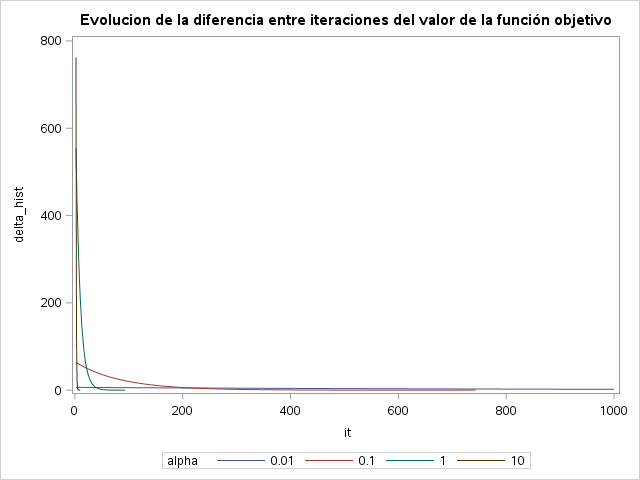

In [22]:

/*
 * Se supone que la función objetivo tiene forma polinomica: y=theta[0]+theta[1]x+theta[2]x^2+...+theta[d]x^d
 * La macro toma como input un dataset con los coeficientes de este polinomio como variables.
 
 * y = theta[0] + theta[1]x + theta[2]x^2
 * r = (beta0 + beta1)*p + beta*p^2
 * theta[0]= 0
 * theta[1]= beta0 + beta1
 * theta[2]= beta
 
 * it: Número de la iteracion actual
 * y_hist: Funcion objetivo (r)
 * x_hist: Argumento (p)
 * delta_hist: Diferencia entre el valor de la funcion objetivo en el paso anterior y el actual
 */

DATA theta;
	set Betas;
	theta0=0;
	theta1=beta0+beta1;
	theta2=beta;
	DROP beta:;
RUN;

%polyGradDescent(data=theta,outSolver=solver1,outHist=hist_conv1,convPlot=N,alpha=0.01,maxIter=1000,epsilon=0.01,x0=0);
%polyGradDescent(data=theta,outSolver=solver2,outHist=hist_conv2,convPlot=N,alpha=0.1,maxIter=1000,epsilon=0.01,x0=0);
%polyGradDescent(data=theta,outSolver=solver3,outHist=hist_conv3,convPlot=N,alpha=1,maxIter=1000,epsilon=0.01,x0=0);
%polyGradDescent(data=theta,outSolver=solver4,outHist=hist_conv4,convPlot=N,alpha=10,maxIter=1000,epsilon=0.01,x0=0);

DATA hist_conv_alpha;
	set hist_conv1 hist_conv2 hist_conv3 hist_conv4;
RUN;
DATA solver_alpha;
	set solver1 solver2 solver3 solver4;
RUN;

title "Estado de la ultima iteracion de cada ejecución del algoritmo";
PROC PRINT DATA=SOLVER_alpha NOOBS;
    id alpha epsilon x0;
    var it x_hist y_hist delta_hist;
RUN;
title "Evolucion de la diferencia entre iteraciones del valor de la función objetivo";
PROC SGPLOT DATA= hist_conv_alpha;
	series x=it y=delta_hist / group=alpha;
RUN;
title


En los resultados expuestos, se observa claramente que el algoritmo converge para los valores de alpha analizados, por lo que se empleará alpha=10 ya que garantiza la convergencia en un menor número de iteraciones.

theta0,theta1,theta2,alpha,epsilon,x0,lastIt,y_solver,x_solver
0,25.3976,-0.02953,35,0.01,0,10,-12116.51,1201.55

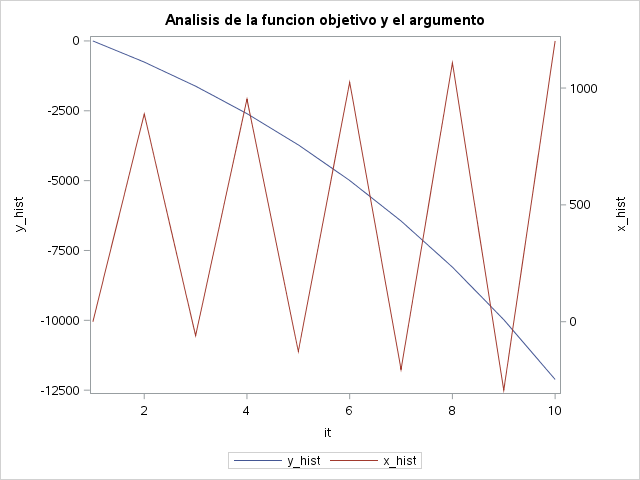
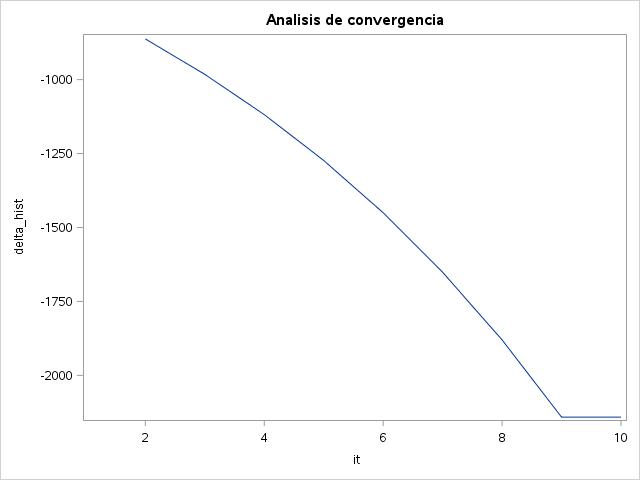

In [17]:
/*Ejemplo de comportamiento divergente: alpha demasiado alto*/
%polyGradDescent(data=theta,outSolver=solver5,outHist=hist_conv5,convPlot=Y,alpha=35,maxIter=10,epsilon=0.01,x0=0);

Este último caso es un contraejemplo en el que se suminstra un valor de alpha demasiado alto para comentar el comportamiento del algoritmo. Nótese que el valor del argumento oscila con cada vez mayor amplitud, y el valor de la función objetivo se va alejando del máximo de la curva.

### Selección del punto incial x0 (initialPrice)

Otro punto que merece la pena analizar es la comprobación de la convergencia para varios valores iniciales de los argumentos. La razón para llevar a cabo este análisis es que puede darse el caso de que exista más de un extremo local de los cuales solo uno será el extremo global. Si a priori se desconoce la topología de la curva, inicializando el algoritmo en varios puntos se puede detectar si converge en todos a la misma solución o si por el contrario, entra en distintas regiones de la curva (o superficie si hay más de un argumento) que hacen "caer" al algoritmo en distintas soluciones. En este caso, hay que inspeccionar el resultado para seleccionar el punto que resulta en  el valor mayor (o menor, en función del tipo de extremo que se busque) de la función objetivo. En este caso, como se sabe que la curva es una parábola y por consiguiente, solo tiene un máximo; se lleva a cabo el ejercicio a modo ilustrativo.

alpha,epsilon,x0,it,x_hist,y_hist,delta_hist
10,0.01,0,10,429.892,5460.87,.002831099
10,0.01,100,9,429.770,5460.87,.009948761
10,0.01,200,9,429.849,5460.87,.004833165
10,0.01,300,8,429.780,5460.87,.009214155

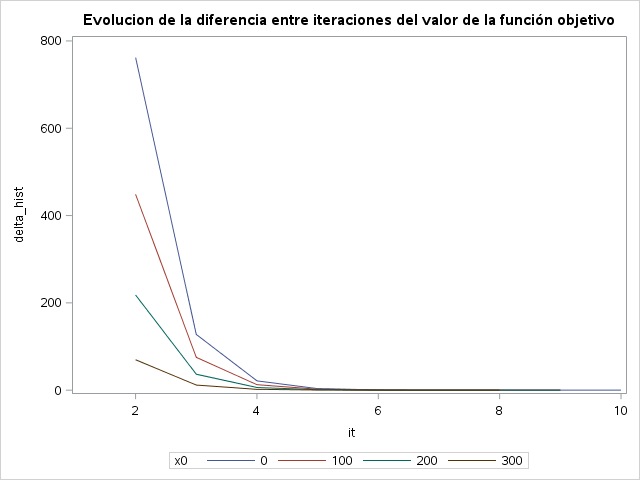

In [20]:
%polyGradDescent(data=theta,outSolver=solver1,outHist=hist_conv1,convPlot=N,alpha=10,maxIter=1000,epsilon=0.01,x0=0);
%polyGradDescent(data=theta,outSolver=solver2,outHist=hist_conv2,convPlot=N,alpha=10,maxIter=1000,epsilon=0.01,x0=100);
%polyGradDescent(data=theta,outSolver=solver3,outHist=hist_conv3,convPlot=N,alpha=10,maxIter=1000,epsilon=0.01,x0=200);
%polyGradDescent(data=theta,outSolver=solver4,outHist=hist_conv4,convPlot=N,alpha=10,maxIter=1000,epsilon=0.01,x0=300);
DATA hist_conv_x0;
	set hist_conv1 hist_conv2 hist_conv3 hist_conv4;
RUN;
DATA solver_x0;
	set solver1 solver2 solver3 solver4;
RUN;

title "Estado de la ultima iteracion de cada ejecución del algoritmo";
PROC PRINT DATA=SOLVER_x0 NOOBS;
    id alpha epsilon x0;
    var it x_hist y_hist delta_hist;
RUN;
title "Evolucion de la diferencia entre iteraciones del valor de la función objetivo";
PROC SGPLOT DATA= hist_conv_x0;
	series x=it y=delta_hist / group=X0;
RUN;
title;

Como esperaba, la solución no cambia al variar el punto inicial. Obviamente, mientras mejor sea la estimación (más próxima al punto buscado), más rápido converge el algoritmo.

theta0,theta1,theta2,alpha,epsilon,x0,lastIt,y_solver,x_solver
0,25.3976,-0.02953,10,0.01,100,9,5460.87,429.770

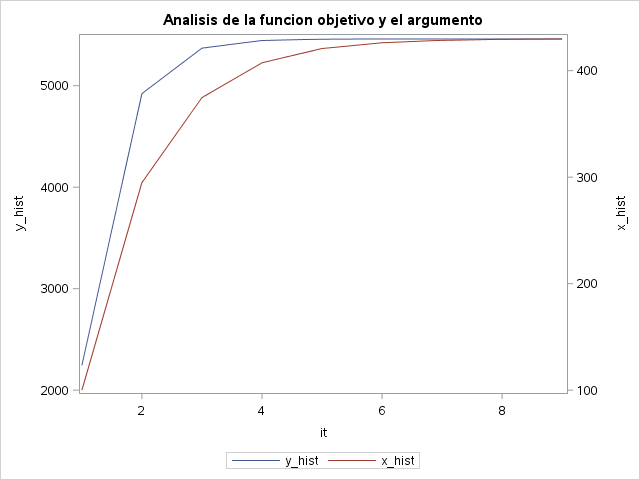
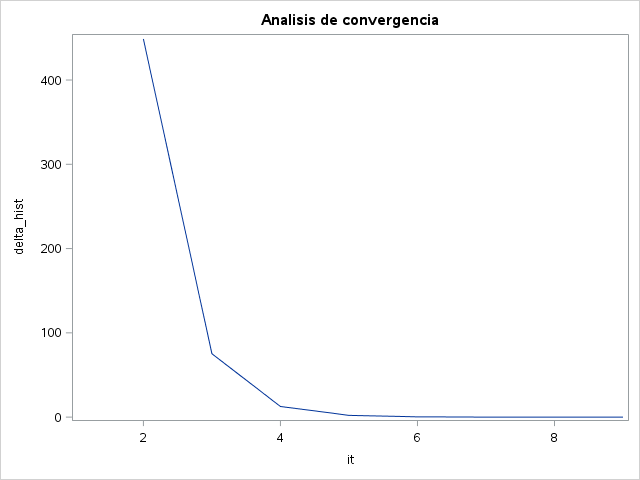

In [19]:
/*Parametrizacion seleccionada*/
%polyGradDescent(data=theta,outSolver=solver_FINAL,outHist=hist_conv_FINAL,convPlot=Y,alpha=10,maxIter=15,epsilon=0.01,x0=100);

La parametrización seleccionada permite alcanzar una solución en pocas iteraciones y explorar la curva de manera satisfactoria. Además, en vista del análisis realizado, se observa que el parámetro que más condiciona la velocidad de convergencia es el ratio de aprendizaje (alpha), sin embargo, hay que subrayar que la estimación inicial (x0) puede ser un parámetro crítico en aquellos casos en los que la curva tenga varios extremos locales.